### Beer Data Science Project

#### Purpose of the project is to explore Beer reviews dataset and find answers to below questions - 

1.	Rank top 3 Breweries which produce the strongest beers?
2.	Which year did beers enjoy the highest ratings? 
3.	Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?
4.	If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

5.	Which Beer style seems to be the favorite based on reviews written by users? 
6.	How does written review compare to overall review score for the beer styles?
7.	How do find similar beer drinkers by using written reviews only?   

#### Steps that we will follow are as below - 
 - Data Ingestion
 - Data Exploration
 - Data Cleaning and Prepropcessing
 - Data Visualization
 - Finding Answers to Questions

### Load essential libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import re
from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# from tqdm.notebook import tqdm
# tqdm.pandas()

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Ingestion

In [14]:
# Data was not able to load with 'utf-8' encoding, so used 'latin-1' encoding
beer_data = pd.read_csv(r"..\data\BeerDataScienceProject.csv", encoding="latin-1")

# Created copy of data to work on
beer_reviews = beer_data.copy()

# Check Data
beer_reviews.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


### Data Exploration

In [15]:
# Check structure of dataset
beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508590 non-null  float64
 1   beer_beerId         528870 non-null  int64  
 2   beer_brewerId       528870 non-null  int64  
 3   beer_name           528870 non-null  object 
 4   beer_style          528870 non-null  object 
 5   review_appearance   528870 non-null  float64
 6   review_palette      528870 non-null  float64
 7   review_overall      528870 non-null  float64
 8   review_taste        528870 non-null  float64
 9   review_profileName  528755 non-null  object 
 10  review_aroma        528870 non-null  float64
 11  review_text         528751 non-null  object 
 12  review_time         528870 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 52.5+ MB


In [16]:
# Check percentage of missing values 
print(f"Missing values in dataset: \n {round(beer_reviews.isnull().sum() * 100 / len(beer_reviews), 2)}")

Missing values in dataset: 
 beer_ABV              3.83
beer_beerId           0.00
beer_brewerId         0.00
beer_name             0.00
beer_style            0.00
review_appearance     0.00
review_palette        0.00
review_overall        0.00
review_taste          0.00
review_profileName    0.02
review_aroma          0.00
review_text           0.02
review_time           0.00
dtype: float64


> As Null values are ~4% for "Beer ABV", we can drop them

In [17]:
# Drop Null values
beer_reviews = beer_reviews.dropna()
beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508358 entries, 0 to 528796
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508358 non-null  float64
 1   beer_beerId         508358 non-null  int64  
 2   beer_brewerId       508358 non-null  int64  
 3   beer_name           508358 non-null  object 
 4   beer_style          508358 non-null  object 
 5   review_appearance   508358 non-null  float64
 6   review_palette      508358 non-null  float64
 7   review_overall      508358 non-null  float64
 8   review_taste        508358 non-null  float64
 9   review_profileName  508358 non-null  object 
 10  review_aroma        508358 non-null  float64
 11  review_text         508358 non-null  object 
 12  review_time         508358 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 54.3+ MB


In [18]:
# Check Duplicate Data

# Sort by overall rating 
beer_reviews = beer_reviews.sort_values('review_overall', ascending=False)

# Keep only highest rating from each user
beer_reviews = beer_reviews.drop_duplicates(subset=['review_profileName', 'beer_name'], keep='first')

beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502769 entries, 492945 to 39638
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            502769 non-null  float64
 1   beer_beerId         502769 non-null  int64  
 2   beer_brewerId       502769 non-null  int64  
 3   beer_name           502769 non-null  object 
 4   beer_style          502769 non-null  object 
 5   review_appearance   502769 non-null  float64
 6   review_palette      502769 non-null  float64
 7   review_overall      502769 non-null  float64
 8   review_taste        502769 non-null  float64
 9   review_profileName  502769 non-null  object 
 10  review_aroma        502769 non-null  float64
 11  review_text         502769 non-null  object 
 12  review_time         502769 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 53.7+ MB


In [19]:
print(f"Percentage of duplicate values: {round((508358 - 502769) / 508358  * 100, 2)}%")

Percentage of duplicate values: 1.1%


> The duplicate values are only ~1% so we are dropping them

### Data Cleaning and Prepropcessing

> Some columns have data type as object, changing them to appropriate data type based on values

In [20]:
# Convert 'object' data type or review_text to 'string'
beer_reviews['review_text'] = beer_reviews['review_text'].astype('string')

In [21]:
# Convert 'object' data type to 'category'
beer_reviews[beer_reviews.select_dtypes(['object']).columns] =\
beer_reviews.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [22]:
# Convert 'review_time' data type from int64 to datetime for better interpretation
beer_reviews['review_time'] = pd.to_datetime(beer_reviews['review_time'], unit = 's')
beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502769 entries, 492945 to 39638
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   beer_ABV            502769 non-null  float64       
 1   beer_beerId         502769 non-null  int64         
 2   beer_brewerId       502769 non-null  int64         
 3   beer_name           502769 non-null  category      
 4   beer_style          502769 non-null  category      
 5   review_appearance   502769 non-null  float64       
 6   review_palette      502769 non-null  float64       
 7   review_overall      502769 non-null  float64       
 8   review_taste        502769 non-null  float64       
 9   review_profileName  502769 non-null  category      
 10  review_aroma        502769 non-null  float64       
 11  review_text         502769 non-null  string        
 12  review_time         502769 non-null  datetime64[ns]
dtypes: category(3), datetime6

> Creating separate copy of data for review text related analysis

In [23]:
# Separatig the text based review from other columns to treat it differently
beer_text_reviews = beer_reviews[['beer_beerId', 'beer_brewerId', 'beer_name', 'review_profileName', 'review_overall', 'beer_style','review_text']].copy()
beer_text_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502769 entries, 492945 to 39638
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   beer_beerId         502769 non-null  int64   
 1   beer_brewerId       502769 non-null  int64   
 2   beer_name           502769 non-null  category
 3   review_profileName  502769 non-null  category
 4   review_overall      502769 non-null  float64 
 5   beer_style          502769 non-null  category
 6   review_text         502769 non-null  string  
dtypes: category(3), float64(1), int64(2), string(1)
memory usage: 22.9 MB


> Using TextBlob Library for text processing  as it is based on NLTK and has facility to give sentiment score which is inoportant to understand reviewers sentiment

In [24]:
# Count the words in review
beer_text_reviews['tokens_count'] = beer_text_reviews['review_text'].apply(lambda x: len(TextBlob(x).words))

In [25]:
# Count the sentences in review
beer_text_reviews['sents'] = beer_text_reviews['review_text'].apply(lambda x: len(TextBlob(x).sentences))

> Word tag information can be used to find relation ships beween user rating and review text


In [27]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [29]:
# beer_text_reviews['tags'] = beer_text_reviews['review_text'].apply(lambda x: TextBlob(x).tags)

> Sentiment  information form text blob returns two properties - polarity, and subjectivity

> Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

> Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

In [30]:
# Sentiment analysis with polarity score to identify if sentiment is positive or not regarding Beer
beer_text_reviews['sentiment_pol'] = beer_text_reviews['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [31]:
# Save Processed file for further Use
beer_text_reviews.to_csv('../data/BeerDataScienceProject_processed_text.csv', encoding='utf-8', index=False)

In [34]:
# Dropping column 'review text' fro mmain dataframe as we have saved text related analysis
beer_reviews.drop(['review_text'], axis=1, inplace=True)

### Data Visualization

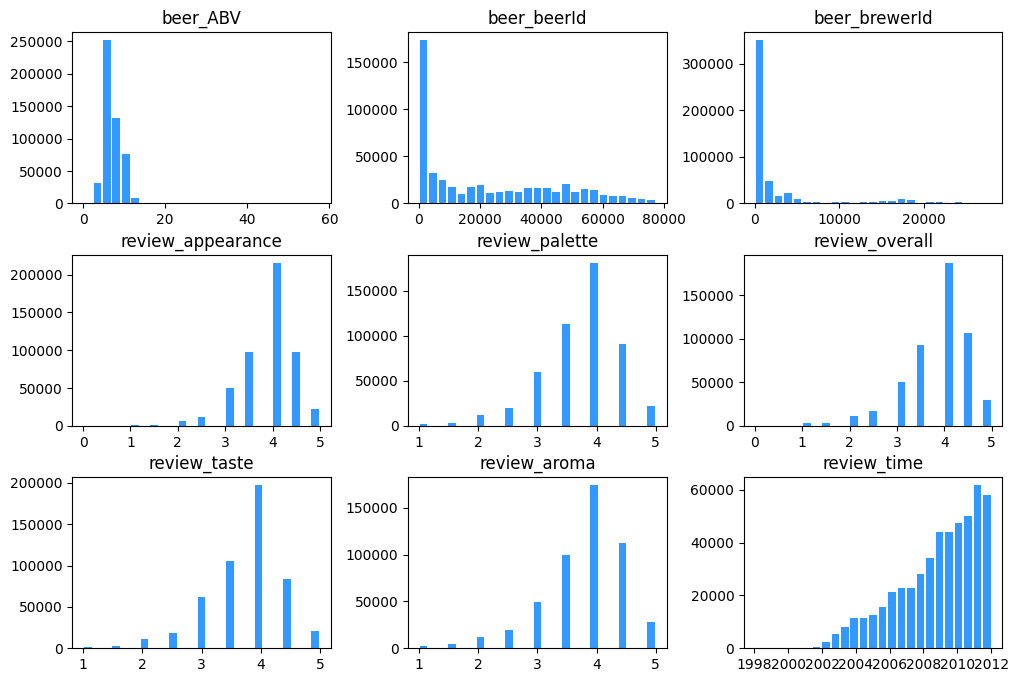

In [35]:
# Histogram of all numeric features
beer_reviews.hist( bins=25, grid=False, figsize=(12,8), color='#3399ff', rwidth=0.8)
plt.savefig('../reports/figures/histogram_of_features.png', bbox_inches='tight')
plt.show()

Histogram analysis -
- beer_ABV - Skewed right - ABV value is less than 20% for most beers           
- review_appearance - Skewed Left - Most beers have rating grater than 3.5 
- review_palette - Normal - Most beers are rated between 3 to 4.5
- review_overall - Skewed left - Mosrt beers have ratig grater than 3    
- review_taste  - Normal - Most beers are rated between 3 to 4.5
- review_aroma - Normal - Most beers are rated between 3 to 4.5
- review_time  - Skewed left - time and  number of beer rated have linear relationship
> There are some reviews with value 0 in review_appearance and review_overall columns

In [36]:
# Ratings with 0 value 
beer_reviews = beer_reviews[(beer_reviews['review_appearance'] >= 1)|(beer_reviews['review_overall'] >= 1)]
beer_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502766 entries, 492945 to 188052
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   beer_ABV            502766 non-null  float64       
 1   beer_beerId         502766 non-null  int64         
 2   beer_brewerId       502766 non-null  int64         
 3   beer_name           502766 non-null  category      
 4   beer_style          502766 non-null  category      
 5   review_appearance   502766 non-null  float64       
 6   review_palette      502766 non-null  float64       
 7   review_overall      502766 non-null  float64       
 8   review_taste        502766 non-null  float64       
 9   review_profileName  502766 non-null  category      
 10  review_aroma        502766 non-null  float64       
 11  review_time         502766 non-null  datetime64[ns]
dtypes: category(3), datetime64[ns](1), float64(6), int64(2)
memory usage: 42.0 MB


> There were only (502769 - 502766) = 3 reviews with value less than 1, which is negligible. But including data that might not be useful should be checked. 

In [37]:
# Save dataset at this stage for further use
beer_reviews.to_csv('../data/BeerDataScienceProject_processed_num_categorical.csv', encoding='utf-8', index=False)

### Finding Answers to Questions

#### For below part we need processed data for numerical and categorical features

In [38]:
# Load the preprocessed data
beer_reviews_processed = pd.read_csv('../data/BeerDataScienceProject_processed_num_categorical.csv', encoding='utf-8')

##### Rank top 3 Breweries which produce the strongest beers?



> According to Wikipedia - The strength of beer is measured by its alcohol content by volume expressed as a percentage, that is to say, the number of millilitres of absolute alcohol (ethanol) in 100 mL of beer. 

> This parameter is called 'Alcohol by Volume' (ABV)

In [39]:
top_strongest_beers = beer_reviews[['beer_name', 'beer_ABV']].sort_values('beer_ABV', ascending=False)

In [40]:
top_strongest_beers = top_strongest_beers.drop_duplicates('beer_name').head(3).sort_values('beer_ABV', ascending=True)

In [41]:
top_strongest_beers

,beer_name,beer_ABV
12913,Schorschbräu Schorschbock 40%,39.44
12909,Schorschbräu Schorschbock 43%,43.00
12889,Schorschbräu Schorschbock 57%,57.70


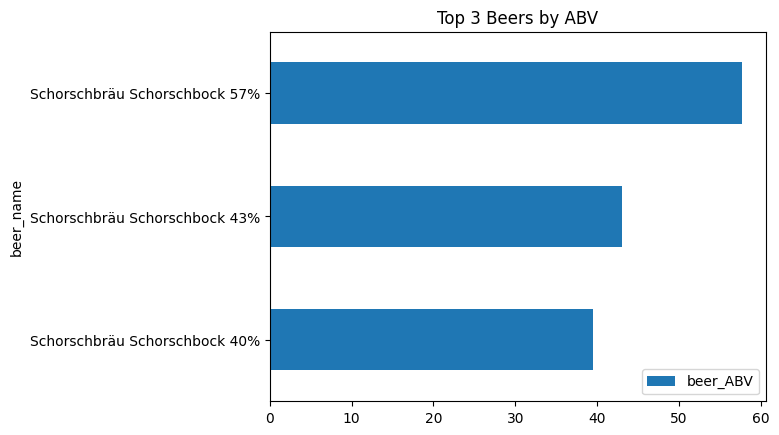

In [42]:
top_strongest_beers.plot.barh(x='beer_name', y='beer_ABV', title='Top 3 Beers by ABV')
plt.savefig('../reports/figures/strongest_beers_by_ABV.png', bbox_inches='tight')
plt.show()

##### Which year did beers enjoy the highest ratings?

> For this we need to extract 'year' information from 'review time' column. 

> After that we can group on 'beer name' and 'review year', then aggregate them on 'overall rating' with maximum rating

In [43]:
beer_reviews['review_year'] = pd.DatetimeIndex(beer_reviews['review_time']).year

C:\Users\Akshay\AppData\Local\Temp\ipykernel_1560\2863249272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beer_reviews['review_year'] = pd.DatetimeIndex(beer_reviews['review_time']).year


In [44]:
beer_peak_rating = beer_reviews[['beer_name', 'review_year', 'review_overall']].groupby(['beer_name', 'review_year'])

In [45]:
beer_peak_rating = beer_peak_rating.agg(max_review_overall=('review_overall', max)).sort_values(by='max_review_overall',ascending=False).reset_index()

In [46]:
beer_peak_rating.drop_duplicates(subset='beer_name', keep='first')

,beer_name,review_year,max_review_overall
0,"Hop, Drop n Roll",2011,5.0
1,Cantillon Kriek 100% Lambic,2008,5.0
5,Slap & Tickle,2010,5.0
6,Hell For Certain,2004,5.0
7,Cantillon La Dernière Cuvée Du 89,2008,5.0
...,...,...,...
39152,Zhigulevskoye Lubitelskoye,2002,1.0
39154,Camino Real Common,2011,1.0
39159,Kopparbergs Special Brew X-Strong 7.5%,2003,1.0
39161,NuBru Blend,2007,1.0


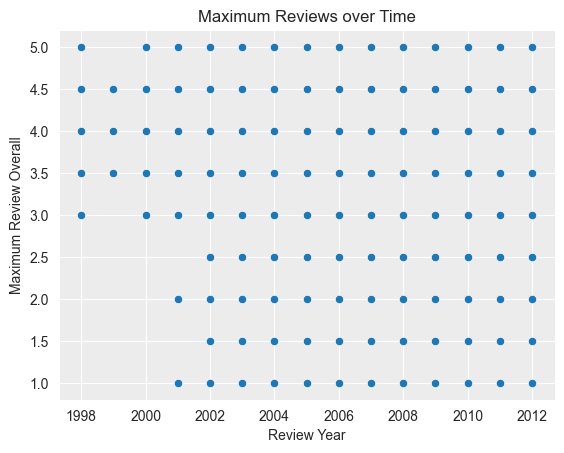

In [47]:
sns.set_style("darkgrid", {"axes.facecolor": ".925"})
sns.scatterplot(data=beer_peak_rating, x='review_year', y='max_review_overall', color="tab:blue")
plt.xlabel('Review Year')
plt.ylabel('Maximum Review Overall')
plt.title('Maximum Reviews over Time')
plt.savefig('../reports/figures/years_with_highest_ratings.png', bbox_inches='tight')
plt.show()

##### Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

> Here we need to calculate correlation of 'review_aroma', 'review_appearance', 'review_palette' and 'review_taste' with 'review_overall'

In [48]:
columns = ['review_aroma', 'review_appearance', 'review_palette', 'review_taste', 'review_overall']

correlation_data = beer_reviews_processed[columns].corr()
correlation_data.style.background_gradient(cmap='Blues')

,review_aroma,review_appearance,review_palette,review_taste,review_overall
review_aroma,1.000000,0.530761,0.702969,0.722349,0.780248
review_appearance,0.530761,1.000000,0.544353,0.551510,0.482716
review_palette,0.702969,0.544353,1.000000,0.600340,0.597762
review_taste,0.722349,0.551510,0.600340,1.000000,0.688937
review_overall,0.780248,0.482716,0.597762,0.688937,1.000000


> There is high correlation betwwen Aroma and Overall review, after that Taste has high corrlation.

##### If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

> To recommend 3 beers to my friends as I do not have experience and preference, I would first find most popular beers from data and then find highest rated beers among them. 
This will increase chance that my recommendations will work for my friends. Also there is always a favour for famous things among public.

In [49]:
top_3_rec = beer_reviews[['beer_name', 'review_overall']]\
  .pivot_table(index='beer_name', aggfunc=('count', 'mean', 'median')).dropna()

# Rename columns and flatten pivot table
top_3_rec.columns = top_3_rec.columns.to_series().str.join('_')
top_3_rec.reset_index(inplace=True)

# Filter for highest rated beers
top_3_rec = top_3_rec.query('review_overall_count >= 1000')\
  .sort_values('review_overall_mean', ascending=False)\
  .head(3)

In [50]:
top_3_rec

,beer_name,review_overall_count,review_overall_mean,review_overall_median
4661,Founders KBS (Kentucky Breakfast Stout),1873,4.402029,4.5
12865,Tröegs Nugget Nectar,1878,4.394835,4.5
4614,Founders Breakfast Stout,2443,4.359394,4.5


#### For below part we need 'review text' related data which we analyzed seprately

In [4]:
beer_text_reviews = pd.read_csv('../data/BeerDataScienceProject_processed_text.csv', encoding='utf-8')

In [5]:
beer_text_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502769 entries, 0 to 502768
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_beerId         502769 non-null  int64  
 1   beer_brewerId       502769 non-null  int64  
 2   beer_name           502769 non-null  object 
 3   review_profileName  502769 non-null  object 
 4   review_overall      502769 non-null  float64
 5   beer_style          502769 non-null  object 
 6   review_text         502769 non-null  object 
 7   tokens_count        502769 non-null  int64  
 8   sents               502769 non-null  int64  
 9   sentiment_pol       502769 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 38.4+ MB


##### Which Beer style seems to be the favorite based on reviews written by users? 

> To find most favourite styles I collected all beer styles and maximum sentiment score from user rating and then selected beer styles with maximum sentiment score

In [6]:
beer_review_sentiment = beer_text_reviews.groupby(['beer_style']).agg(max_sent_score=('sentiment_pol', max))
beer_review_sentiment = beer_review_sentiment.sort_values(['max_sent_score'], ascending=False).reset_index()


In [7]:
top_review_sentiment = beer_review_sentiment['max_sent_score'].values == 1
top_beers_from_review_sentiment = beer_review_sentiment[top_review_sentiment]

In [8]:
print(f"Most Favourite Beer Styles - {', '.join(top_beers_from_review_sentiment.beer_style.to_list())}")

Most Favourite Beer Styles - Dubbel, Irish Red Ale, Belgian Strong Dark Ale, American Double / Imperial Stout, American Stout, Scotch Ale / Wee Heavy, Belgian Strong Pale Ale, Winter Warmer, American Amber / Red Lager


> To find most favourite styles I collected all beer styles and maximum sentiment score from user rating and overall rating then selected beer styles with maximum of both scores

In [9]:
# Top beers from review sentiment_and overall rating
beers_rev_sent_and_rating = beer_text_reviews.groupby(['beer_style']).agg(max_review_overall=('review_overall', max), max_sentiment_score=('sentiment_pol', max))

In [10]:
beers_rev_sent_and_rating.sort_values(['max_review_overall', 'max_sentiment_score'], ascending=(False, False)).reset_index()

,beer_style,max_review_overall,max_sentiment_score
0,American Amber / Red Lager,5.0,1.000000
1,American Double / Imperial Stout,5.0,1.000000
2,American Stout,5.0,1.000000
3,Belgian Strong Dark Ale,5.0,1.000000
4,Belgian Strong Pale Ale,5.0,1.000000
...,...,...,...
99,Bière de Champagne / Bière Brut,5.0,0.412500
100,Faro,5.0,0.409444
101,Eisbock,5.0,0.375138
102,Sahti,5.0,0.366829


In [11]:
top_beers_from_rev_sent_and_rating = beers_rev_sent_and_rating[(beers_rev_sent_and_rating['max_sentiment_score'] == 1 )\
    & (beers_rev_sent_and_rating['max_review_overall'] == 5.0)]

In [12]:
print(f"Most Favourite Beer Styles from Sentiment and Overall Rating - {', '.join(top_beers_from_rev_sent_and_rating.index.values)}")

Most Favourite Beer Styles from Sentiment and Overall Rating - American Amber / Red Lager, American Double / Imperial Stout, American Stout, Belgian Strong Dark Ale, Belgian Strong Pale Ale, Dubbel, Irish Red Ale, Scotch Ale / Wee Heavy, Winter Warmer


##### How does written review compare to overall review score for the beer styles?

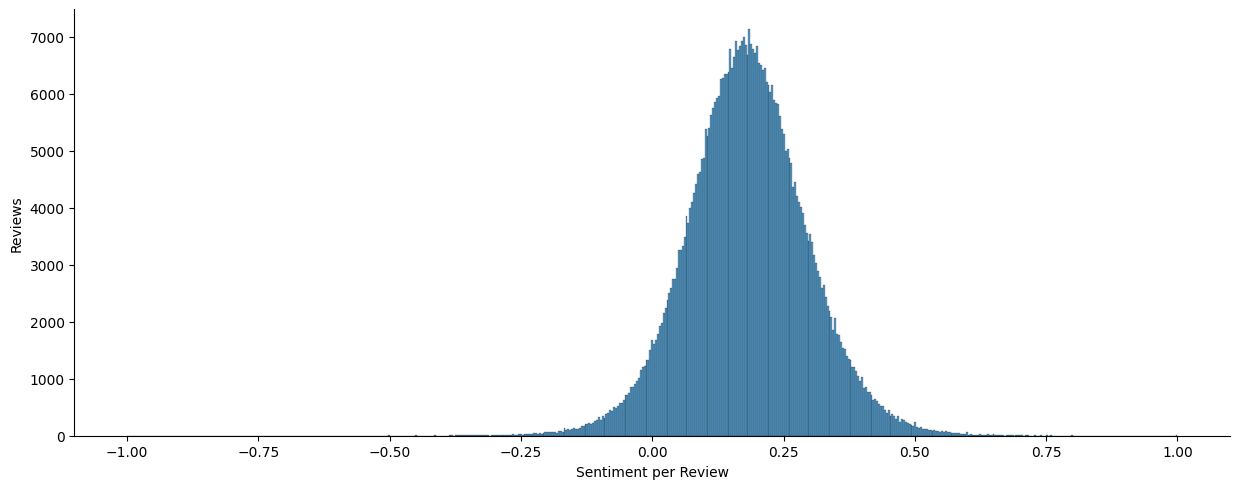

In [13]:
sns.displot(data=beer_text_reviews, x='sentiment_pol', aspect=2.5, color="tab:blue")
plt.xlabel('Sentiment per Review')
plt.ylabel('Reviews')
sns.despine()
plt.savefig('../reports/figures/snetiment_score_per_review_distribution.png', bbox_inches='tight')
plt.show()

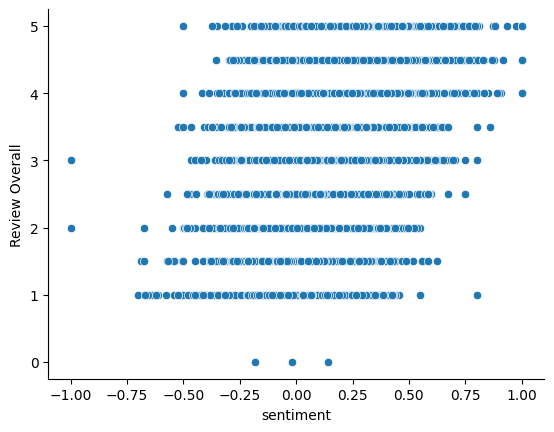

In [14]:

sns.scatterplot(data=beer_text_reviews, y='review_overall', x='sentiment_pol', color="tab:blue")
plt.xlabel('sentiment')
plt.ylabel('Review Overall')
sns.despine()
plt.savefig('../reports/figures/sentiment_and_overall_review_relation.png', bbox_inches='tight')
plt.show()

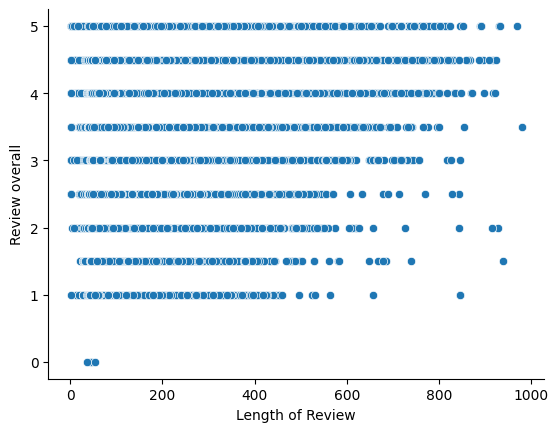

In [15]:
sns.scatterplot(data=beer_text_reviews, x='tokens_count', y='review_overall', color="tab:blue")
plt.xlabel('Length of Review')
plt.ylabel('Review overall')
sns.despine()
plt.savefig('../reports/figures/sentiment_and_length_of_review_relation.png', bbox_inches='tight')
plt.show()

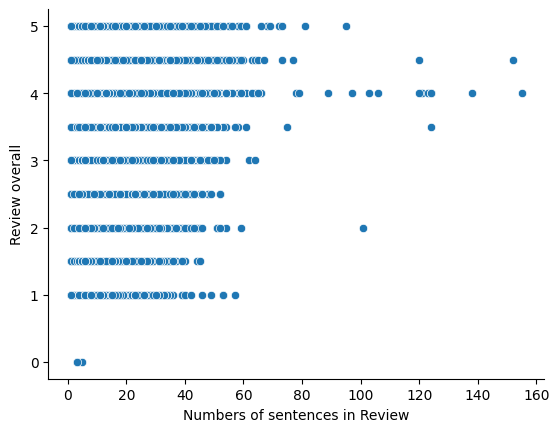

In [36]:
sns.scatterplot(data=beer_text_reviews, x='sents', y='review_overall', color="tab:blue")
plt.xlabel('Numbers of sentences in Review')
plt.ylabel('Review overall')
sns.despine()
plt.savefig('../reports/figures/sentiment_and_total_sent_review_relation.png', bbox_inches='tight')
plt.show()

> Here, to go deep in relation between writen review and overall rating, we can use count of adjectives in review text 

Reference - http://jmcauley.ucsd.edu/cse255/projects/wi15/Benjamin_Braun_Robert%20Timpe.pdf

> From above graphs we can say that Positive reviews tend to me lengthy, and negative reviews are shorter in comparison

##### How do find similar beer drinkers by using written reviews only?

> Collaborative filtering uses algorithms to filter data from user reviews to make personalized recommendations for users with similar preferences. With this we can find out similar beer drinkers.

> Three types of collaborative filtering commonly used in recommendation systems are neighbor-based, item-to-item and classification- based.

> In neighbor-based filtering, users are selected for their similarity to the active user. This similarity is determined by matching users who have posted similar reviews. Based on the previous similarity, it is presumed that future likes and dislikes will also be similar. From the average rating of the group, recommendations are made for the active user.

> An item-to-item filtering process uses a matrix to determine the likeness of pairs of items. Item-to-item processes then compare the current user’s preference to the items in the matrix for similarities upon which to base recommendations.

> A classification-based collaborative filtering system recommends things based on how similar users liked that classification or genre. It is assumed that users that enjoy or dislike similar experiences within a classification will also enjoy others within that classification.

> Here I am trying out content based filtering on sample of data to find out if we can get similar users if given a user

In [160]:
beer_text_reviews.head()

,beer_beerId,beer_brewerId,beer_name,review_profileName,review_overall,beer_style,review_text,tokens_count,sents,sentiment_pol
0,1339,132,Hazelnut Brown Nectar,prosper,5.0,American Brown Ale,"Served at ~15C. Gorgeous pour. Nut brown, slig...",119,13,0.258824
1,689,221,Red Stripe Jamaican Lager,AussieInPhilly,5.0,American Adjunct Lager,"This beer is tops. The crisp, yet smooth taste...",61,7,0.393827
2,15881,694,Tröegs Nugget Nectar,abents,5.0,American Amber / Red Ale,Thanks to mikereaser for sending this in a tra...,205,13,0.307530
3,571,113,Samuel Smith's Oatmeal Stout,cuzinpete00,5.0,Oatmeal Stout,this beer is a must try. very drinkable and ve...,52,5,0.330000
4,689,221,Red Stripe Jamaican Lager,lordbrad1,5.0,American Adjunct Lager,I've never met anyone that didn't like this be...,86,5,0.059398


In [16]:
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = clean_spcl.sub(' ', text)
    text = clean_symbol.sub('', text)
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text

# Selecting small sample for expirement

beer_text_sample = beer_text_reviews.groupby('review_profileName', group_keys=False).apply(lambda x: x.sample(frac=0.05))
beer_text_sample['review_clean'] = beer_text_sample['review_text'].apply(clean_text)

In [17]:
beer_text_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23322 entries, 74759 to 269350
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   beer_beerId         23322 non-null  int64  
 1   beer_brewerId       23322 non-null  int64  
 2   beer_name           23322 non-null  object 
 3   review_profileName  23322 non-null  object 
 4   review_overall      23322 non-null  float64
 5   beer_style          23322 non-null  object 
 6   review_text         23322 non-null  object 
 7   tokens_count        23322 non-null  int64  
 8   sents               23322 non-null  int64  
 9   sentiment_pol       23322 non-null  float64
 10  review_clean        23322 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.1+ MB


In [18]:
beer_text_sample.set_index('review_profileName', inplace=True)
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(beer_text_sample['review_clean'])

> Here Profile name is used as index to train TF IDF vectorizer using cleaned review text

In [19]:
beer_text_sample.head(10)

,beer_beerId,beer_brewerId,beer_name,review_overall,beer_style,review_text,tokens_count,sents,sentiment_pol,review_clean
review_profileName,,,,,,,,,,
0110x011,7531,694,Tröegs Mad Elf,4.5,Belgian Strong Dark Ale,"2007 release. Pours a murky copper, bordering ...",106,10,0.017857,2007 release pours murky copper bordering red ...
0110x011,42533,140,Sierra Nevada Southern Hemisphere Harvest Fres...,4.5,American IPA,pours a crystal clear copper with a one finger...,54,4,0.236667,pours crystal clear copper one finger head qui...
05Harley,51679,94,Imperial Porter (Brewmaster Series),4.5,American Porter,Botled on 9/21/11 Purchased @ Johnsons Market ...,143,12,0.216900,botled 9 21 11 purchased johnsons market place...
05Harley,72789,20417,White Birch Birchwood Smoked Stout,4.5,Smoked Beer,"Bottled on 5/11, batch 1, bottle #1152 Purchas...",195,13,0.259492,bottled 5 11 batch 1 bottle #1152 purchased jo...
0tt0,694,22,Don de Dieu,4.5,Belgian Strong Pale Ale,"750 ml bottle, with a ""best by"" date of 12/14/...",175,18,0.221667,750 ml bottle best date 12 14 08 decanted duve...
100floods,51420,5318,Santa's Little Helper - Bourbon Barrel Aged,3.0,American Double / Imperial Stout,I am drinking one of the many uncarbonated bat...,191,16,0.153897,drinking one many uncarbonated batches provide...
100floods,30420,140,Sierra Nevada Torpedo Extra IPA,4.5,American IPA,"Pours a nice amber/burnt orange, nice cream he...",115,9,0.335965,pours nice amber burnt orange nice cream head ...
1099,576,113,Samuel Smith's Nut Brown Ale,4.5,English Brown Ale,This is my second review of a Samuel Smiths pr...,163,11,0.226104,second review samuel smiths product thus far i...
1121987,35409,433,Rickard's White,5.0,Witbier,i saw a post about this rating higher than hoe...,129,10,0.171852,saw post rating higher hoegarden blind tasting...


> Now we calculate Cosine similarity of obtained tfidf matrix to get similrity scores for all users in sample

In [20]:
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [41]:
# getting indices from dataframe for matching with input to function which finds similar user
indices = pd.Series(beer_text_sample.index)

In [42]:
indices[:10]

0      0110x011
1      0110x011
2      05Harley
3      05Harley
4          0tt0
5     100floods
6     100floods
7          1099
8       1121987
9    11osixBrew
Name: review_profileName, dtype: object

In [43]:
# function to find similar beer drinkers

def similar_beer_drinkers(profile_name, cos_sim = cos_sim):
    
    similar_profile_name = []
    
    idx = indices[indices == profile_name].index[0]

    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    top_5_indexes = list(score_series.iloc[1:6].index)
    
    for i in top_5_indexes:
        similar_profile_name.append(list(beer_text_sample.index)[i])
        
    return similar_profile_name

In [44]:
# List of similar beer drinkers for given profile name
group_similar = similar_beer_drinkers('prosper')

In [45]:
group_similar

['tdm168', 'PhillyCop', 'jsprain1', 'DJED69', 'arboristfish']

In [46]:
# dumping tfidf vocabulary and model 
import pickle
pickle.dump(tf.vocabulary_, open('../models/features.pkl','wb'))
pickle.dump(tf, open('../models/tfidf_vect_model.pk', 'wb'))

> Finding out entries for similar users found by function

In [47]:
beer_text_reviews.loc[beer_text_reviews['review_profileName'].isin(group_similar)].drop_duplicates(['beer_style'])

,beer_beerId,beer_brewerId,beer_name,review_profileName,review_overall,beer_style,review_text,tokens_count,sents,sentiment_pol
3963,2671,140,Sierra Nevada Bigfoot Barleywine Style Ale,arboristfish,5.0,American Barleywine,"The beer pours a cloudy amber color, and the h...",97,7,0.124333
5807,1503,35,Sam Adams Light,arboristfish,5.0,Light Lager,There arent to many beers that I would give a ...,79,7,0.414643
6867,246,81,Heineken Lager Beer,PhillyCop,5.0,Euro Pale Lager,I love this beer! I always find Heineken to be...,53,5,0.335208
8643,11757,1199,Founders Breakfast Stout,jsprain1,5.0,American Double / Imperial Stout,A- Pours a very dark brown. It approaches but ...,216,16,0.263623
8943,576,113,Samuel Smith's Nut Brown Ale,jsprain1,5.0,English Brown Ale,A- Pours a readish brown with a perfect head t...,105,12,0.475463
...,...,...,...,...,...,...,...,...,...,...
425876,747,221,Dragon Stout,jsprain1,3.0,Foreign / Export Stout,A- Pours an almost solid black with a thin kha...,76,7,0.086111
452161,64089,35,Infinium,tdm168,3.0,Bière de Champagne / Bière Brut,"After all the posted disappointment, I was hes...",188,12,0.075056
452600,38366,35,Samuel Adams Dunkelweizen,arboristfish,3.0,Dunkelweizen,"This beer pours a cloudy copperish color, with...",70,7,0.160714
482526,115,156,Butthead Doppelbock,jsprain1,2.5,Doppelbock,"A- pours a red tinted brown. But seriously, wh...",160,14,0.083820
